In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_parquet('train_mfti.parquet', engine='pyarrow')
display(train_data)

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
0,2022-08-01,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,951f53de61764ea0b51317200a0dbbfc,show_vacancy
1,2022-08-01,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
2,2022-08-01,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
3,2022-08-01,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
4,2022-08-01,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
...,...,...,...,...,...,...
12292583,2022-08-11,1660246479,162851,0d3c58c6864546c689fa0997de484b30,18124998fd644e80b667a1d84bf63846,preview_click_response
12292584,2022-08-11,1660246106,136818,ef559274a81e4ff4b92aa3e9f6805886,5c71c1f1b7cf492ba05871c400a05250,preview_click_response
12292585,2022-08-11,1660250139,143721,c4453128ae584dca8f2a8d20a7c74263,33c968125459420e89ffbc8cffece317,preview_click_response
12292586,2022-08-11,1660250318,154423,c4453128ae584dca8f2a8d20a7c74263,33c968125459420e89ffbc8cffece317,preview_click_response


_--Техническая информация, не все идеи проверены --_

Что может быть подозрательного в юзере? 

- У одного cookie много юзеров
- Один куки делал слишком много нажатий
- Один куки нажимал слишком часто
- Юзеры тыкают одни и те же вакансии

Что может быть странного в вакансии? 

- она слишком кликабельна?
- она сликшом кликабельна в определенный момент
- у вакансии много неинтересных действий и мало интересных? Тогда можем исключить
- вакансию тыкают одни и те же юзеры

# Подозрительные вакансии

Посчитаем кол-во кликов, кол-во юзеров на вакансию

In [7]:
grouped = train_data.groupby(by=['vacancy_id_'])

stat = []

for vac, group in grouped:
    cookie = group['cookie_id'].nunique()
    event_type = group.shape[0]
    
    if cookie == 1:
        cookie_name = group['cookie_id'].unique()[0]
    else:
        cookie_name = None
    
    stat.append([vac, cookie, cookie_name, event_type])

Попробуем отсортировать по кол-ву юзеров

In [40]:
stats = pd.DataFrame.from_records(stat, columns=['vacancy_id_', '#cookie_id', 'cookie_name', '#event_type'])
stats.sort_values(by=['#cookie_id'], ascending=False).head(20)

,vacancy_id_,#cookie_id,cookie_name,#event_type
160153,260154,18662,None,59105
98113,198114,16674,None,50187
103403,203404,16284,None,45634
11504,111505,15088,None,35095
102607,202608,14524,None,41620
64601,164602,14285,None,36850
48713,148714,13061,None,35629
107422,207423,11988,None,38607
158440,258441,10930,None,24253
16822,116823,10901,None,40023


<AxesSubplot:>

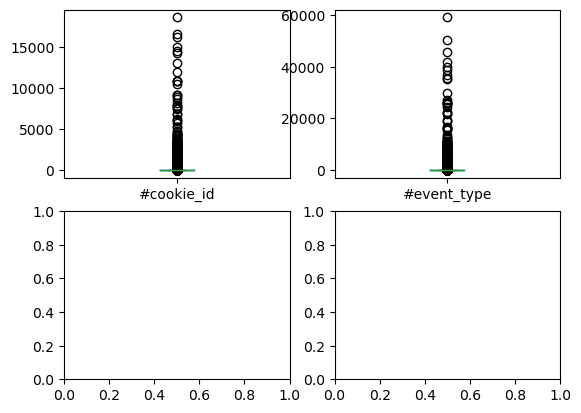

In [27]:
fig, ax = plt.subplots(2, 2)

stats['#cookie_id'].plot.box(ax=ax[0, 0])
stats['#event_type'].plot.box(ax=ax[0, 1])

Ящик с усами показал, что выбросов очень много, однако не представляется возможным оценить среднее. Выведем describe

In [31]:
stats.describe()

,vacancy_id_,#cookie_id,#event_type,%conversion
count,160167.00000,160167.000000,160167.000000,160167.000000
mean,180084.00000,29.210668,76.748569,2.380850
std,46236.37462,175.746648,484.159623,0.981177
min,100001.00000,1.000000,1.000000,1.000000
25%,140042.50000,4.000000,10.000000,2.000000
50%,180084.00000,10.000000,24.000000,2.333333
75%,220125.50000,23.000000,59.000000,2.777778
max,260167.00000,18662.000000,59105.000000,107.888889


Судя по std, значения в 16-18 тысяч действительно аномальные. Но что, если мы просто имеем дело с очень популярными вакансиями? Скажем, есть какая-то средняя пропорция 3:1 - три клика на 1 пользователя, и для этих аномальных вакансий она соблюдается? Давайте сначала визуально оценим, есть ли зависимость кол-ва кликов от кол-ва юзеров

<AxesSubplot:xlabel='#event_type', ylabel='#cookie_id'>

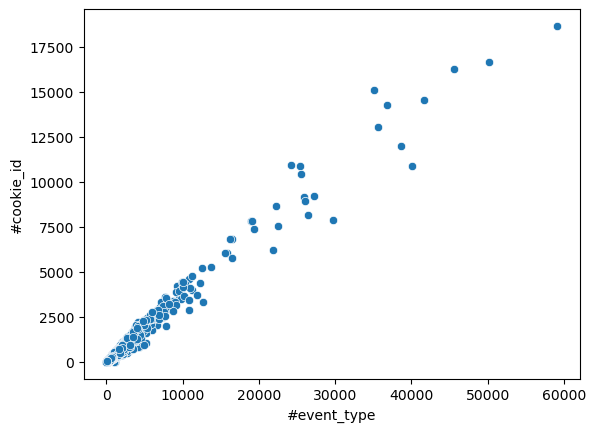

In [33]:
sns.scatterplot(data=stats, x="#event_type", y='#cookie_id')

Да, корреляция определенно есть. Посмотрим поближе

(0.0, 100.0)

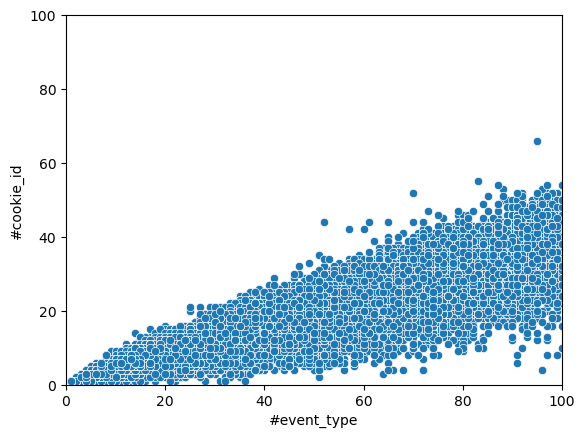

In [35]:
sns.scatterplot(data=stats, x="#event_type", y='#cookie_id')
plt.xlim([0, 100])
plt.ylim([0, 100])

А теперь посчитаем конверсию - кол-во действий поделим на кол-во юзеров. И отсортируем 

In [50]:
stats['%conversion'] = stats['#event_type'] / stats['#cookie_id']
stats.sort_values(by=['%conversion'], ascending=False).head(20)

,vacancy_id_,#cookie_id,cookie_name,#event_type,%conversion
130076,230077,9,None,971,107.888889
63624,163625,14,None,1178,84.142857
63009,163010,1,184034b698e845119e25424e67ad3d8c,36,36.000000
134669,234670,1,b906ba2c16a747cc80249161ef78d527,32,32.000000
80907,180908,1,925cfb4e9df147d9a9ed6f4e7af6972b,31,31.000000
25502,125503,1,c806b88e43034c8f87589c24188e1710,28,28.000000
55404,155405,2,None,51,25.500000
90735,190736,4,None,96,24.000000
45597,145598,1,2611364cd2cb4377bdeaaf5edbc76457,22,22.000000
2668,102669,3,None,64,21.333333


почти все записи из топ-20 выглядят подозрительно. 14 человек совершили 1178 кликов по одной и той же вакансии?

In [44]:
stats['%conversion'].describe()

count    160167.000000
mean          2.380850
std           0.981177
min           1.000000
25%           2.000000
50%           2.333333
75%           2.777778
max         107.888889
Name: %conversion, dtype: float64

Согласно статичтике, люди в среднем совершают 2.3 клика с отклонением в +/- 1 клик. И есть оценка квартилей. Сколько подозрительных вакансий мы имеем, если оценивать по 1 и 3 квартилю?

In [59]:
q_low = stats["%conversion"].quantile(0.25)
q_hi  = stats["%conversion"].quantile(0.75)

stats[(stats["%conversion"] < q_hi) & (stats["%conversion"] > q_low)]

,vacancy_id_,#cookie_id,cookie_name,#event_type,%conversion
0,100001,20,None,49,2.450000
2,100003,29,None,60,2.068966
5,100006,46,None,110,2.391304
6,100007,357,None,811,2.271709
7,100008,33,None,87,2.636364
...,...,...,...,...,...
160148,260149,27,None,65,2.407407
160149,260150,16,None,35,2.187500
160150,260151,6,None,14,2.333333
160160,260161,714,None,1704,2.386555


67307 остается, остальные подозрительные, около 100 000. Слишком много. Попробуем построить распределение

(0.0, 20.0)

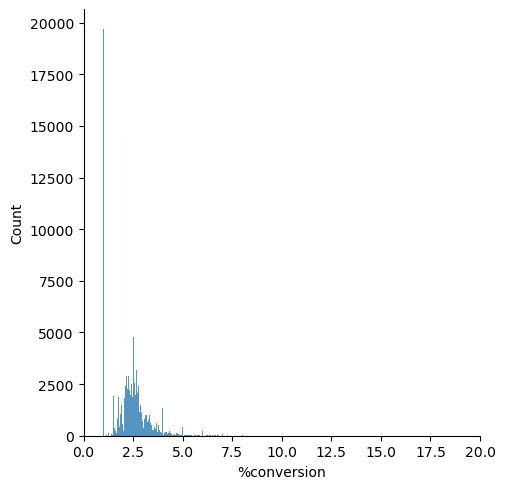

In [48]:
sns.displot(stats["%conversion"])
plt.xlim([0, 20])

Видим, что есть много вакансий с конверсией около 1, неясно, что это могло бы значить. Может, вакансия только появилась или она неинтересная и лучше ее не рекомендовать. Попробуем исключить такие вакансии, чтобы понять, как изменится картина

(0.0, 20.0)

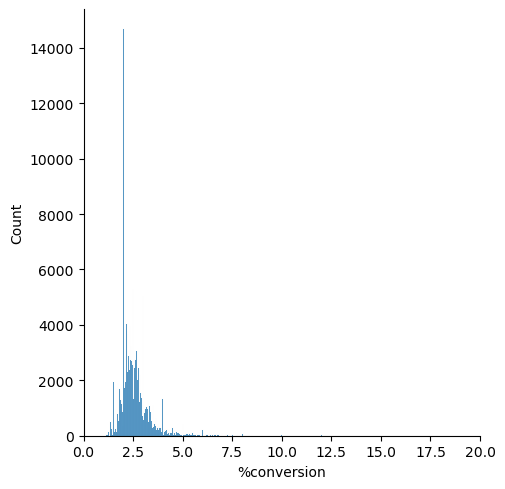

In [55]:
sns.displot(stats[stats["%conversion"] != 1]["%conversion"])
plt.xlim([0, 20])

Все равно остался какой-то выброс. Посмотрим еще описание

In [56]:
stats[stats["%conversion"] != 1].describe()

,vacancy_id_,#cookie_id,#event_type,%conversion
count,140490.000000,140490.000000,140490.000000,140490.000000
mean,179308.387757,33.138964,87.335013,2.574252
std,45907.988254,187.316003,516.071679,0.890551
min,100001.000000,1.000000,2.000000,1.090909
25%,140017.250000,6.000000,14.000000,2.076923
50%,178864.500000,12.000000,29.000000,2.425532
75%,218261.750000,26.000000,68.000000,2.857143
max,260167.000000,18662.000000,59105.000000,107.888889


А сколько выбросов в таком случае отсекается?


In [60]:
stats_not1 = stats[stats["%conversion"] != 1]
q_low = stats_not1["%conversion"].quantile(0.25)
q_hi  = stats_not1["%conversion"].quantile(0.75)

stats_not1[(stats_not1["%conversion"] < q_hi) & (stats_not1["%conversion"] > q_low)]

,vacancy_id_,#cookie_id,cookie_name,#event_type,%conversion
0,100001,20,None,49,2.450000
5,100006,46,None,110,2.391304
6,100007,357,None,811,2.271709
7,100008,33,None,87,2.636364
9,100010,63,None,140,2.222222
...,...,...,...,...,...
160149,260150,16,None,35,2.187500
160150,260151,6,None,14,2.333333
160156,260157,34,None,95,2.794118
160160,260161,714,None,1704,2.386555


осталось 69801 вакансий. Уже лучше, но все равно слишком много выбросов

Вообще, распределение похоже на нормальное, попробуем отсечь по 3 * сигма

In [91]:
sigma3 = 3 * stats["%conversion"].std()
mean = stats["%conversion"].mean()

sigma3_vacs = stats[(stats["%conversion"] < mean + sigma3) & (stats["%conversion"] >  mean - sigma3)]
sigma3_vacs

,vacancy_id_,#cookie_id,cookie_name,#event_type,%conversion
0,100001,20,None,49,2.450000
1,100002,224,None,847,3.781250
2,100003,29,None,60,2.068966
3,100004,3,None,4,1.333333
4,100005,3,None,9,3.000000
...,...,...,...,...,...
160162,260163,9,None,18,2.000000
160163,260164,1,9c50bca324dd4401bec14c601b7a5102,1,1.000000
160164,260165,42,None,102,2.428571
160165,260166,7,None,13,1.857143


Вот так выглядит логичнее. Еще посмотрим описание и график

In [66]:
stats.describe()

,vacancy_id_,#cookie_id,#event_type,%conversion
count,160167.00000,160167.000000,160167.000000,160167.000000
mean,180084.00000,29.210668,76.748569,2.380850
std,46236.37462,175.746648,484.159623,0.981177
min,100001.00000,1.000000,1.000000,1.000000
25%,140042.50000,4.000000,10.000000,2.000000
50%,180084.00000,10.000000,24.000000,2.333333
75%,220125.50000,23.000000,59.000000,2.777778
max,260167.00000,18662.000000,59105.000000,107.888889


(0.0, 10.0)

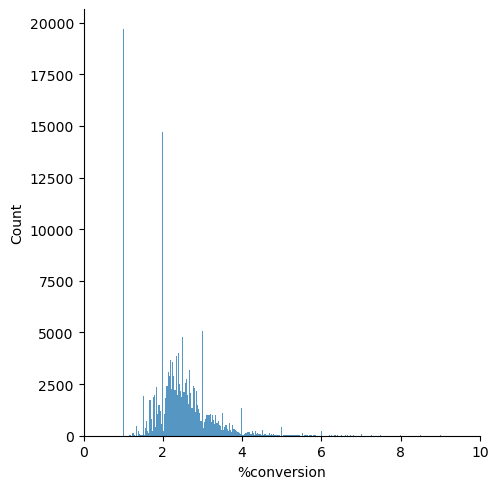

In [71]:
sns.displot(stats['%conversion'])
plt.xlim([0, 10])

Составим список ваканси, которые берем для обучения

In [92]:
good_vacs = sigma3_vacs['vacancy_id_']
good_vacs

0         100001
1         100002
2         100003
3         100004
4         100005
           ...  
160162    260163
160163    260164
160164    260165
160165    260166
160166    260167
Name: vacancy_id_, Length: 158686, dtype: int64

# Подозрительные пользователи

In [72]:
display(train_data)

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
0,2022-08-01,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,951f53de61764ea0b51317200a0dbbfc,show_vacancy
1,2022-08-01,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
2,2022-08-01,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
3,2022-08-01,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
4,2022-08-01,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
...,...,...,...,...,...,...
12292583,2022-08-11,1660246479,162851,0d3c58c6864546c689fa0997de484b30,18124998fd644e80b667a1d84bf63846,preview_click_response
12292584,2022-08-11,1660246106,136818,ef559274a81e4ff4b92aa3e9f6805886,5c71c1f1b7cf492ba05871c400a05250,preview_click_response
12292585,2022-08-11,1660250139,143721,c4453128ae584dca8f2a8d20a7c74263,33c968125459420e89ffbc8cffece317,preview_click_response
12292586,2022-08-11,1660250318,154423,c4453128ae584dca8f2a8d20a7c74263,33c968125459420e89ffbc8cffece317,preview_click_response


In [73]:
train_data['cookie_id'].nunique(), train_data['user_id'].nunique(), train_data[train_data['user_id'].isnull()].shape[0]

(330180, 209335, 3581411)

У нас 
- 330180 уникальных куки
- 209335 уникальных пользователей
- 3581411 записей без user_id

Похоже, некоторым куки соответствует несколько пользователей. Поищем аномалии. Для этого посчитаем количество юзеров, соответствующих каждому куки

In [74]:
cookie_groups = train_data.groupby(by=['cookie_id'])

In [76]:
cookie_stat = []

for cookie, group in cookie_groups:
    users = group['user_id'].nunique()
    cookie_stat.append([cookie, users])

In [88]:
cookie_stat = pd.DataFrame.from_records(cookie_stat, columns=['cookie', '#user_id'])
cookie_stat.sort_values(by=['#user_id'], ascending=False)

,cookie,#user_id
35859,1b803f7c3d8640439d577002c88265a9,56
93799,48746516d7d54828bad15167ae006d98,8
231594,b313d862d2954ef096b1268c1d7b8aba,7
311604,f17d07a6229c43259a7ee40d3d2d46c8,5
90112,4595475c54234d57b0b66d4d431f2a58,5
...,...,...
75308,3a0a9f6d38ca4ed481f1a1bedb8ac6ee,0
75309,3a0aa65b69e84d429587bdf3a6b74784,0
215547,a67ffff33ac349ed8a7491893b31bc2f,0
215545,a67fc8e0127140569acbf2736b993330,0


куки с 56 пользователями выглядит очень странно. Какой-то обещственный компьютер? Посмотрим описание и частоты

In [89]:
cookie_stat.describe()

,#user_id
count,330180.000000
mean,0.659237
std,0.492296
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,56.000000


In [90]:
cookie_stat['#user_id'].value_counts()

1     215167
0     113830
2       1124
3         47
4          5
5          4
56         1
8          1
7          1
Name: #user_id, dtype: int64

Видимо, из обучения можно исключить тех, у кого больше трех user_id

In [93]:
cookie_stat[cookie_stat['#user_id'] <= 3]

,cookie,#user_id
0,0000c4548c3944c08972bbdc1fa4eb85,1
1,0000d7508334414ca792c5ff66eb8c14,0
2,0000e63f423542fe8090575b611cea4d,1
3,00013bf3e58244b48d4dbdf43543c30c,0
4,00015019b0594984afc3fd9fa9557490,1
...,...,...
330175,ffff3581b7e7405db25fac5c5dd1bff9,1
330176,ffff42fe199b46d59ce38bde9c95b148,0
330177,ffff8283d29644e69ad6d08cc3ca7fb7,1
330178,ffffd6d4f2134dd6aa80ff71e942b508,1


Отберем куки для обучения

In [94]:
good_cookie = cookie_stat['cookie']
good_cookie

0         0000c4548c3944c08972bbdc1fa4eb85
1         0000d7508334414ca792c5ff66eb8c14
2         0000e63f423542fe8090575b611cea4d
3         00013bf3e58244b48d4dbdf43543c30c
4         00015019b0594984afc3fd9fa9557490
                        ...               
330175    ffff3581b7e7405db25fac5c5dd1bff9
330176    ffff42fe199b46d59ce38bde9c95b148
330177    ffff8283d29644e69ad6d08cc3ca7fb7
330178    ffffd6d4f2134dd6aa80ff71e942b508
330179    ffffdb17f45b4032b386d691d52e6c00
Name: cookie, Length: 330180, dtype: object

## Отбор строк для обучения

Мы вычисили подозрительные вакансии и подозрительных юзеров. Теперь удалим их из общего датасета

In [97]:
cleared_data = train_data[train_data['cookie_id'].isin(good_cookie) & train_data['vacancy_id_'].isin(good_vacs)]

In [98]:
cleared_data.head()

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
0,2022-08-01,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,951f53de61764ea0b51317200a0dbbfc,show_vacancy
1,2022-08-01,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
2,2022-08-01,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
3,2022-08-01,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
4,2022-08-01,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy


# Поделим на train/val

Перемешаем

In [100]:
shuffled = cleared_data.sample(frac=1)
shuffled

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
773418,2022-08-04,1659618587,139779,6ba2bc862b2847a1a0e31944d40715f1,203ca90198774deda274d3cf91859d06,show_vacancy
1544563,2022-08-09,1660046466,159237,17d1e8c408aa4752abfaaea5de3660b7,4115e2c0e75a4cd6b692d05a2a61b2b2,show_vacancy
8633959,2022-09-18,1663532081,189558,48005adc338a43e382567eab1be9ebdd,a5fb1281c3d54ee281bcd75f15d95fec,show_vacancy
6818182,2022-09-09,1662700793,183798,1c392a12605c440bbc148578e8523c98,2be91f6e72e9424ab7d50208cfa2aa34,preview_click_vacancy
2491490,2022-08-17,1660750599,217242,f892097982ef492c8bae9dfd9024c101,b4b50be6d3ea4e2b8213b4bd17b24f73,preview_click_vacancy
...,...,...,...,...,...,...
9830898,2022-09-25,1664118675,210469,8e1578ae81234216a586f0d8e78eaef2,b17b4214ed744322ace7a54d4754c544,preview_click_vacancy
987181,2022-08-05,1659692206,258441,58f3628d99ce4991adc423954f910919,None,show_vacancy
6825610,2022-09-09,1662714715,207775,33f921343cdc4149a4185d66b2eaf10d,8acd00371c6e4de69f58db9fba44971b,show_vacancy
1674001,2022-08-09,1660055707,248720,c3529b7aacc445b3bc33b19a79bf19bd,fdf70370b6b84946a9e1163b785c92a1,show_vacancy


In [102]:
split_no = int(shuffled.shape[0] * 0.8)
split_no

9779404

Поделим

In [103]:
train, val = shuffled[:split_no], shuffled[split_no:]

Сохраним

In [114]:
train.to_parquet('processed_train.parquet', index=False)

In [111]:
# val.to_parquet('processed_val.parquet', index=False)

Чтобы потом было удобно оценивать val датасет сразу его преобзразуем. Будет соответствие куки - список вакансий

In [115]:
val_vacs = val.groupby(by='cookie_id')['vacancy_id_'].apply(list)
val_vacs = pd.DataFrame({'cookie_id': val_vacs.index, 'vacancy_id_': val_vacs.values})
val_vacs

,cookie_id,vacancy_id_
0,0000c4548c3944c08972bbdc1fa4eb85,"[182445, 137659, 187529]"
1,0000d7508334414ca792c5ff66eb8c14,"[250327, 230581, 192850, 178195]"
2,0000e63f423542fe8090575b611cea4d,"[188335, 122287, 122287, 141592]"
3,00013bf3e58244b48d4dbdf43543c30c,"[135961, 138688, 138688]"
4,00015019b0594984afc3fd9fa9557490,"[113482, 111941, 115924, 111505, 242642, 12735..."
...,...,...
321342,ffff3581b7e7405db25fac5c5dd1bff9,"[102780, 207423, 102780, 235862]"
321343,ffff42fe199b46d59ce38bde9c95b148,"[258148, 257870, 137744, 124315, 117383, 14731..."
321344,ffff8283d29644e69ad6d08cc3ca7fb7,"[115949, 115949]"
321345,ffffd6d4f2134dd6aa80ff71e942b508,"[230870, 225522, 155987, 102931, 225522, 10293..."


In [116]:
val_vacs.to_parquet('processed_val.parquet', index=False)